# Loading Data + Make Basic Observations

In [17]:
# Load the data
import pandas as pd
train_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/train.csv")
test_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/test.csv")

In [18]:
# Get all of the unique labels for train / test sets 
train_labels = list(train_df['room'].unique())
test_labels = list(test_df['room'].unique())

# Labels that appear in BOTH train and test
common_labels = list(set(train_labels) & set(test_labels))

# Now filter the train_df and test_df so that
# remove all record in train_df whose labels not in test labels 
# and remove all record in test_df whose labels not in train labels 
# therefore we can have a proper train and test df such that the labels appear 
# in train and test should be the same and vice versa
train_df = train_df[train_df['room'].isin(common_labels)].reset_index(drop=True)
test_df  = test_df[test_df['room'].isin(common_labels)].reset_index(drop=True)

In [19]:
# sanity check for label matching between train and test set
assert set(train_df['room'].unique()) == set(test_df['room'].unique())
print("Train/Test labels are now perfectly aligned")

Train/Test labels are now perfectly aligned


In [20]:
# check the distribution of classes in training set
train_df['room'].value_counts()

room
nurse station    488303
cafeteria        171492
kitchen          132819
hallway           63848
523               22169
511                8505
522                8079
cleaning           6232
506                4995
512                3773
520                3695
501                3415
517                1397
513                1152
502                 801
518                 252
Name: count, dtype: int64

In [21]:
# so now we could determine the minority classes would be room 502 and 518
minority_classes = ['502', '518']

# define the target number of records for these minority classes after we done 
# relabeling + concatenating with original training set
TARGET_NUM_502 = 1000 
TARGET_NUM_518 = 1200

# Create fixed 25 - beacons vector

In [22]:
# Function to add 25 beacon_1, beacon_2, ... , beacon_25
def add_beacon_features(df, num_beacons=25):
    df = df.copy()

    for i in range(1, num_beacons + 1):
        df[f'beacon_{i}'] = df['RSSI'].where(df['mac address'] == i, 0)

    return df

# Apply with our current train and test dataframe
train_df = add_beacon_features(train_df)
test_df = add_beacon_features(test_df)

In [23]:
train_df.head(1)

,timestamp,mac address,RSSI,room,beacon_1,beacon_2,beacon_3,beacon_4,beacon_5,beacon_6,...,beacon_16,beacon_17,beacon_18,beacon_19,beacon_20,beacon_21,beacon_22,beacon_23,beacon_24,beacon_25
0,2023-04-10 14:21:46+09:00,6,-93,kitchen,0,0,0,0,0,-93,...,0,0,0,0,0,0,0,0,0,0


In [24]:
test_df.head(1)

,timestamp,mac address,RSSI,room,beacon_1,beacon_2,beacon_3,beacon_4,beacon_5,beacon_6,...,beacon_16,beacon_17,beacon_18,beacon_19,beacon_20,beacon_21,beacon_22,beacon_23,beacon_24,beacon_25
0,2023-04-12 10:00:53+09:00,4,-92,cafeteria,0,0,0,-92,0,0,...,0,0,0,0,0,0,0,0,0,0


# Perform relabelling with KL Divergence for defining "matching"

### Define 6 surrounding beacon's vectors

In [25]:
# Define the 6-beacon surrounding vectors for each room
# Format: [front-left, side-left, source, front, side-right, front-right]
# Based on the 5th floor map
# ONLY including rooms that appear in BOTH train and test sets

beacon_layout = {
    # Rooms from value_counts that are patient rooms
    '501': [16, 2, 1, 15, None, 13],      # Room 1
    '502': [17, 3, 2, 16, 1, 15],         # Room 2 - MINORITY CLASS
    '506': ["to be determined later"],    # Room 6
    '511': [23, 12, 11, 22, 10, 21],      # Room 11
    '512': [None, None, 12, 23, 11, 22],  # Room 12
    '513': [None, None, 13, None, 15, 1],      # Room 13
    '517': [2, 16, 17, 3, None, 5],      # Room 17
    '518': [None, 9, 18, 7, 20, 8],         # Room 18 - MINORITY CLASS
    '520': [7, 18, 20, 8, 21, 10],       # Room 20
    '522': [10, 21, 22, 11, 23, 12],      # Room 22
    '523': [11, 22, 23, 12, None, None],  # Room 23
}

# Classify rooms by matching type
full_matching_rooms = [room for room, beacons in beacon_layout.items() 
                       if None not in beacons]

partial_matching_rooms = list(beacon_layout.keys())

print(f"Total rooms defined: {len(beacon_layout)}")
print(f"Full matching rooms (complete 6 beacons): {full_matching_rooms}")
print(f"Total partial matching rooms: {len(partial_matching_rooms)}")
print(f"\nMinority classes: {minority_classes}")
print(f"Room 502 beacons: {beacon_layout['502']}")
print(f"Room 518 beacons: {beacon_layout['518']}")

Total rooms defined: 11
Full matching rooms (complete 6 beacons): ['502', '506', '511', '520', '522']
Total partial matching rooms: 11

Minority classes: ['502', '518']
Room 502 beacons: [17, 3, 2, 16, 1, 15]
Room 518 beacons: [None, 9, 18, 7, 20, 8]


### Function to calculate KL Divergence -> find best matched candidate for minority classes

In [26]:
import numpy as np
from scipy.stats import entropy

def calculate_kl_divergence(df, minority_vector, majority_vector, minority_room, majority_room):
    """
    Calculate KL divergence between two beacon vectors.
    Supports both full matching (all 6 beacons) and partial matching (some None values).
    
    Args:
        df: DataFrame with beacon columns (beacon_1 to beacon_25)
        minority_vector: List of 6 beacon IDs for minority room [fl, sl, s, f, sr, fr]
        majority_vector: List of 6 beacon IDs for majority room
        minority_room: Room label for minority class (e.g., '502')
        majority_room: Room label for majority class (e.g., '511')
    
    Returns:
        total_kl: float (sum of KL divergence for all valid beacon pairs)
        matching_type: str ('full' or 'partial')
    """
    
    # Filter data for each room
    minority_data = df[df['room'] == minority_room].copy()
    majority_data = df[df['room'] == majority_room].copy()
    
    # Determine matching type and valid beacon indices
    valid_indices = []
    for i in range(6):
        if minority_vector[i] is not None and majority_vector[i] is not None:
            valid_indices.append(i)
    
    # Determine matching type
    if len(valid_indices) == 6:
        matching_type = 'full'
    else:
        matching_type = 'partial'
    
    # Downsample majority to match minority size
    n_minority = len(minority_data)
    if len(majority_data) > n_minority:
        majority_data_sampled = majority_data.sample(n=n_minority, random_state=42)
    else:
        majority_data_sampled = majority_data
    
    # Calculate KL divergence for each valid beacon pair
    total_kl = 0.0
    epsilon = 1e-10  # Small value to avoid log(0)
    
    for idx in valid_indices:
        minority_beacon = minority_vector[idx]
        majority_beacon = majority_vector[idx]
        
        # Get RSSI values for this beacon
        minority_rssi = minority_data[f'beacon_{minority_beacon}'].values
        majority_rssi = majority_data_sampled[f'beacon_{majority_beacon}'].values
        
        # Filter out zeros (no detection)
        minority_rssi = minority_rssi[minority_rssi != 0]
        majority_rssi = majority_rssi[majority_rssi != 0]
        
        # Skip if either has no valid detections
        if len(minority_rssi) == 0 or len(majority_rssi) == 0:
            continue
        
        # Create histograms to convert to probability distributions
        # RSSI typically ranges from -100 to 0 dBm
        bins = np.linspace(-100, 0, 50)
        
        # Get histogram counts
        p_hist, _ = np.histogram(minority_rssi, bins=bins)
        q_hist, _ = np.histogram(majority_rssi, bins=bins)
        
        # Normalize to probability distributions
        p_dist = (p_hist + epsilon) / (p_hist.sum() + epsilon * len(p_hist))
        q_dist = (q_hist + epsilon) / (q_hist.sum() + epsilon * len(q_hist))
        
        # Calculate KL divergence: D_KL(P || Q)
        kl_value = entropy(p_dist, q_dist)
        total_kl += kl_value
    
    return total_kl, matching_type

# Test for BOTH minority classes: 502 and 518
print("=" * 80)
print("TESTING KL DIVERGENCE FOR MINORITY CLASSES")
print("=" * 80)

for minority_room in ['502', '518']:
    print(f"\n{'='*80}")
    print(f"MINORITY CLASS: Room {minority_room}")
    print(f"Sample count: {len(train_df[train_df['room'] == minority_room])}")
    print(f"Beacon vector: {beacon_layout[minority_room]}")
    print(f"{'='*80}\n")
    
    minority_vec = beacon_layout[minority_room]
    
    # Separate candidates into full and partial matching
    full_candidates = []
    partial_candidates = []
    
    for candidate_room, candidate_vec in beacon_layout.items():
        if candidate_room == minority_room:
            continue
        
        # Skip rooms with incomplete beacon layout definition
        if len(candidate_vec) != 6:
            print(f"Skipping Room {candidate_room}: beacon layout not fully defined")
            continue
        
        # Check if this would be full or partial matching
        valid_count = sum(1 for i in range(6) 
                         if minority_vec[i] is not None and candidate_vec[i] is not None)
        
        if valid_count == 6:
            full_candidates.append(candidate_room)
        else:
            partial_candidates.append(candidate_room)
    
    # Test FULL MATCHING candidates
    print("FULL MATCHING CANDIDATES:")
    print("-" * 80)
    full_results = {}
    for candidate_room in full_candidates:
        candidate_vec = beacon_layout[candidate_room]
        kl_score, match_type = calculate_kl_divergence(
            train_df, 
            minority_vec, 
            candidate_vec,
            minority_room,
            candidate_room
        )
        full_results[candidate_room] = kl_score
        print(f"Room {minority_room} vs Room {candidate_room}: KL = {kl_score:.6f} ({match_type})")
    
    if full_results:
        best_full = min(full_results, key=full_results.get)
        print(f"\n>>> BEST FULL MATCH: Room {best_full} with KL = {full_results[best_full]:.6f}")
    else:
        print("No full matching candidates available")
    
    # Test PARTIAL MATCHING candidates
    print(f"\n{'='*80}")
    print("PARTIAL MATCHING CANDIDATES:")
    print("-" * 80)
    partial_results = {}
    for candidate_room in partial_candidates:
        candidate_vec = beacon_layout[candidate_room]
        kl_score, match_type = calculate_kl_divergence(
            train_df, 
            minority_vec, 
            candidate_vec,
            minority_room,
            candidate_room
        )
        partial_results[candidate_room] = kl_score
        valid_beacons = sum(1 for i in range(6) 
                           if minority_vec[i] is not None and candidate_vec[i] is not None)
        print(f"Room {minority_room} vs Room {candidate_room}: KL = {kl_score:.6f} ({match_type}, {valid_beacons}/6 beacons)")
    
    if partial_results:
        best_partial = min(partial_results, key=partial_results.get)
        print(f"\n>>> BEST PARTIAL MATCH: Room {best_partial} with KL = {partial_results[best_partial]:.6f}")
    else:
        print("No partial matching candidates available")
    
    print("\n")

TESTING KL DIVERGENCE FOR MINORITY CLASSES

MINORITY CLASS: Room 502
Sample count: 801
Beacon vector: [17, 3, 2, 16, 1, 15]

Skipping Room 506: beacon layout not fully defined
FULL MATCHING CANDIDATES:
--------------------------------------------------------------------------------
Room 502 vs Room 511: KL = 22.934792 (full)
Room 502 vs Room 520: KL = 7.630353 (full)
Room 502 vs Room 522: KL = 2.949143 (full)

>>> BEST FULL MATCH: Room 522 with KL = 2.949143

PARTIAL MATCHING CANDIDATES:
--------------------------------------------------------------------------------
Room 502 vs Room 501: KL = 17.570795 (partial, 5/6 beacons)
Room 502 vs Room 512: KL = 21.277543 (partial, 4/6 beacons)
Room 502 vs Room 513: KL = 5.105597 (partial, 3/6 beacons)
Room 502 vs Room 517: KL = 15.095895 (partial, 5/6 beacons)
Room 502 vs Room 518: KL = 52.682750 (partial, 5/6 beacons)
Room 502 vs Room 523: KL = 2.610885 (partial, 4/6 beacons)

>>> BEST PARTIAL MATCH: Room 523 with KL = 2.610885



MINORITY CLA

### Random Sample -> Relabel -> Add to initial training set

In [27]:
def relabel_and_augment(df, minority_room, matched_room, target_count, beacon_layout):
    """
    Sample records from matched majority class, relabel them, and add to training data.
    
    Args:
        df: Original training DataFrame
        minority_room: Minority class room label (e.g., '502')
        matched_room: Best matched majority room label (e.g., '522')
        target_count: Target number of samples for minority class after augmentation
        beacon_layout: Dictionary mapping rooms to beacon vectors
    
    Returns:
        augmented_df: DataFrame with relabeled records added
        n_relabeled: Number of records that were relabeled
    """
    
    # Get current count of minority class
    current_count = len(df[df['room'] == minority_room])
    
    # Calculate how many records we need to relabel
    n_relabel = target_count - current_count
    
    if n_relabel <= 0:
        print(f"Room {minority_room} already has {current_count} samples (target: {target_count}). No relabeling needed.")
        return df, 0
    
    print(f"Room {minority_room}: Current = {current_count}, Target = {target_count}")
    print(f"Need to relabel {n_relabel} records from Room {matched_room}")
    
    # Get all records from matched majority room
    matched_room_data = df[df['room'] == matched_room].copy()
    
    if len(matched_room_data) < n_relabel:
        print(f"WARNING: Room {matched_room} only has {len(matched_room_data)} records, less than needed {n_relabel}")
        print(f"Will use all available records from Room {matched_room}")
        n_relabel = len(matched_room_data)
    
    # Randomly sample n_relabel records from matched room
    relabeled_data = matched_room_data.sample(n=n_relabel, random_state=42).copy()
    
    # RELABEL: Change room label from matched_room to minority_room
    # Keep ALL beacon RSSI values unchanged
    relabeled_data['room'] = minority_room
    
    print(f"Relabeled {len(relabeled_data)} records: {matched_room} → {minority_room}")
    
    # Concatenate with original training data
    augmented_df = pd.concat([df, relabeled_data], ignore_index=True)
    
    # Verify
    new_count = len(augmented_df[augmented_df['room'] == minority_room])
    print(f"After augmentation: Room {minority_room} has {new_count} samples")
    
    return augmented_df, n_relabel


# Apply relabeling for both minority classes
print("=" * 80)
print("RELABELING AND AUGMENTATION")
print("=" * 80)

# Store the matches we found
best_matches = {
    '502': '522',  # Room 502 → Room 522 (full matching)
    '518': '513',  # Room 518 → Room 513 (partial matching)
}

target_counts = {
    '502': TARGET_NUM_502,
    '518': TARGET_NUM_518
}

# Start with original training data
augmented_train_df = train_df.copy()

# Apply relabeling for each minority class
for minority_room in ['502', '518']:
    print(f"\n{'='*80}")
    matched_room = best_matches[minority_room]
    target_count = target_counts[minority_room]
    
    augmented_train_df, n_relabeled = relabel_and_augment(
        augmented_train_df,
        minority_room,
        matched_room,
        target_count,
        beacon_layout
    )
    print()

# Final verification
print("=" * 80)
print("FINAL CLASS DISTRIBUTION AFTER AUGMENTATION")
print("=" * 80)
print(augmented_train_df['room'].value_counts())
print(f"\nOriginal training size: {len(train_df)}")
print(f"Augmented training size: {len(augmented_train_df)}")
print(f"Added records: {len(augmented_train_df) - len(train_df)}")

RELABELING AND AUGMENTATION



Room 502: Current = 801, Target = 1000
Need to relabel 199 records from Room 522
Relabeled 199 records: 522 → 502
After augmentation: Room 502 has 1000 samples


Room 518: Current = 252, Target = 1200
Need to relabel 948 records from Room 513
Relabeled 948 records: 513 → 518
After augmentation: Room 518 has 1200 samples

FINAL CLASS DISTRIBUTION AFTER AUGMENTATION
room
nurse station    488303
cafeteria        171492
kitchen          132819
hallway           63848
523               22169
511                8505
522                8079
cleaning           6232
506                4995
512                3773
520                3695
501                3415
517                1397
518                1200
513                1152
502                1000
Name: count, dtype: int64

Original training size: 920927
Augmented training size: 922074
Added records: 1147


### Feature Engineering Function + Apply Windowing

In [28]:
# ============================================================================
# FIXED VERSION - Proper column naming for 'room'
# ============================================================================

# Cell 1: Define the aggregation function (FIXED)
def aggregate_by_timestamp(df):
    """
    Aggregate beacon data by timestamp (1-second windows)
    Since timestamp is already at second precision, this naturally creates 1-second windows
    """
    df = df.copy()
    
    # Build aggregation dictionary
    agg_dict = {}
    
    # For each of the 25 beacons: mean, std, max, min, count
    for i in range(1, 26):
        beacon_col = f'beacon_{i}'
        agg_dict[beacon_col] = ['mean', 'std', 'max', 'min', 'count']
    
    # For room: take first value (should be consistent within same timestamp)
    agg_dict['room'] = 'first'
    
    # Group by timestamp and aggregate
    windowed_df = df.groupby('timestamp').agg(agg_dict)
    
    # Flatten multi-level column names
    new_columns = []
    for col in windowed_df.columns.values:
        if col[0] == 'room':
            # Keep 'room' as is, don't add '_first'
            new_columns.append('room')
        elif col[1]:
            # For beacon columns, join with underscore
            new_columns.append('_'.join(col))
        else:
            new_columns.append(col[0])
    
    windowed_df.columns = new_columns
    
    # Reset index to make timestamp a regular column
    windowed_df = windowed_df.reset_index()
    
    # Fill NaN (happens when std calculated on single value) with 0
    windowed_df = windowed_df.fillna(0)
    
    # CRITICAL: Filter out windows where NO beacons were detected
    # This prevents the "room 0" issue
    beacon_mean_cols = [f'beacon_{i}_mean' for i in range(1, 26)]
    valid_windows = windowed_df[beacon_mean_cols].sum(axis=1) != 0
    
    removed_count = (~valid_windows).sum()
    windowed_df = windowed_df[valid_windows].reset_index(drop=True)
    
    print(f"Total windows after aggregation: {len(windowed_df)}")
    print(f"Removed {removed_count} empty windows (no beacon detections)")
    
    return windowed_df


# Apply aggregation to training data
print("Aggregating training data by timestamp...")
windowed_train_df = aggregate_by_timestamp(train_df)

print("\nTraining data shape after windowing:", windowed_train_df.shape)
print("\nRoom distribution:")
print(windowed_train_df['room'].value_counts())


# Apply aggregation to test data
print("\nAggregating test data by timestamp...")
windowed_test_df = aggregate_by_timestamp(test_df)

print("\nTest data shape after windowing:", windowed_test_df.shape)
print("\nRoom distribution:")
print(windowed_test_df['room'].value_counts())

Aggregating training data by timestamp...
Total windows after aggregation: 15052
Removed 0 empty windows (no beacon detections)

Training data shape after windowing: (15052, 127)

Room distribution:
room
nurse station    7222
cafeteria        3320
kitchen          2885
hallway           620
523               232
522               181
512               159
cleaning          108
511                96
520                70
506                65
501                50
517                15
513                15
502                 9
518                 5
Name: count, dtype: int64

Aggregating test data by timestamp...
Total windows after aggregation: 5889
Removed 0 empty windows (no beacon detections)

Test data shape after windowing: (5889, 127)

Room distribution:
room
kitchen          1703
nurse station    1265
cafeteria        1248
cleaning          475
hallway           326
520               190
513               180
512               133
523               110
506                97
502

In [29]:
windowed_train_df.head()

,timestamp,beacon_1_mean,beacon_1_std,beacon_1_max,beacon_1_min,beacon_1_count,beacon_2_mean,beacon_2_std,beacon_2_max,beacon_2_min,...,beacon_24_std,beacon_24_max,beacon_24_min,beacon_24_count,beacon_25_mean,beacon_25_std,beacon_25_max,beacon_25_min,beacon_25_count,room
0,2023-04-10 14:21:46+09:00,0.0,0.0,0,0,111,0.0,0.0,0,0,...,0.0,0,0,111,0.0,0.0,0,0,111,kitchen
1,2023-04-10 14:21:47+09:00,0.0,0.0,0,0,99,0.0,0.0,0,0,...,0.0,0,0,99,0.0,0.0,0,0,99,kitchen
2,2023-04-10 14:21:48+09:00,0.0,0.0,0,0,67,0.0,0.0,0,0,...,0.0,0,0,67,0.0,0.0,0,0,67,kitchen
3,2023-04-10 14:21:49+09:00,0.0,0.0,0,0,107,0.0,0.0,0,0,...,0.0,0,0,107,0.0,0.0,0,0,107,kitchen
4,2023-04-10 14:21:50+09:00,0.0,0.0,0,0,98,0.0,0.0,0,0,...,0.0,0,0,98,0.0,0.0,0,0,98,kitchen


In [30]:
windowed_test_df.head()

,timestamp,beacon_1_mean,beacon_1_std,beacon_1_max,beacon_1_min,beacon_1_count,beacon_2_mean,beacon_2_std,beacon_2_max,beacon_2_min,...,beacon_24_std,beacon_24_max,beacon_24_min,beacon_24_count,beacon_25_mean,beacon_25_std,beacon_25_max,beacon_25_min,beacon_25_count,room
0,2023-04-12 10:00:53+09:00,0.0,0.0,0,0,25,0.0,0.0,0,0,...,0.0,0,0,25,0.0,0.0,0,0,25,cafeteria
1,2023-04-12 10:00:54+09:00,0.0,0.0,0,0,15,0.0,0.0,0,0,...,0.0,0,0,15,0.0,0.0,0,0,15,cafeteria
2,2023-04-12 10:00:55+09:00,0.0,0.0,0,0,15,0.0,0.0,0,0,...,0.0,0,0,15,0.0,0.0,0,0,15,cafeteria
3,2023-04-12 10:00:56+09:00,0.0,0.0,0,0,10,0.0,0.0,0,0,...,0.0,0,0,10,0.0,0.0,0,0,10,cafeteria
4,2023-04-12 10:00:57+09:00,0.0,0.0,0,0,10,0.0,0.0,0,0,...,0.0,0,0,10,0.0,0.0,0,0,10,cafeteria


### Train XGBoost Models

In [31]:
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Prepare training data
print("=" * 80)
print("TRAINING XGBOOST MODEL")
print("=" * 80)

# Separate features and labels
feature_cols = [col for col in windowed_train_df.columns 
                if col not in ['room', 'timestamp']]

X_train = windowed_train_df[feature_cols]
y_train = windowed_train_df['room']

print(f"Training samples: {len(X_train)}")
print(f"Number of features: {len(feature_cols)}")
print(f"Number of classes: {len(y_train.unique())}")
print(f"Class distribution:\n{y_train.value_counts()}\n")

# Encode labels for XGBoost (XGBoost requires numeric labels)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Calculate class weights for balanced training (macro F1 optimization)
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Train XGBoost with parameters optimized for macro F1
xgb_model = xgb.XGBClassifier(
    n_estimators=100,           # Number of boosting rounds
    max_depth=6,                # Maximum tree depth (usually shallower than RF)
    learning_rate=0.1,          # Step size shrinkage
    min_child_weight=1,         # Minimum sum of instance weight in a child
    subsample=0.8,              # Subsample ratio of training instances
    colsample_bytree=0.8,       # Subsample ratio of columns when constructing each tree
    gamma=0,                    # Minimum loss reduction for split
    reg_alpha=0,                # L1 regularization
    reg_lambda=1,               # L2 regularization
    objective='multi:softmax',  # Multiclass classification
    num_class=len(y_train.unique()),
    eval_metric='mlogloss',     # Evaluation metric
    random_state=42,
    n_jobs=-1,
    tree_method='hist'          # Faster histogram-based algorithm
)

print("Training XGBoost...")
xgb_model.fit(
    X_train, 
    y_train_encoded,
    sample_weight=sample_weights  # Apply class balancing through sample weights
)
print("Training completed!")

# Training accuracy
train_pred_encoded = xgb_model.predict(X_train)
train_pred = label_encoder.inverse_transform(train_pred_encoded)
train_f1 = f1_score(y_train, train_pred, average='macro')
print(f"\nTraining Macro F1-Score: {train_f1:.4f}")

TRAINING XGBOOST MODEL
Training samples: 15052
Number of features: 125
Number of classes: 16
Class distribution:
room
nurse station    7222
cafeteria        3320
kitchen          2885
hallway           620
523               232
522               181
512               159
cleaning          108
511                96
520                70
506                65
501                50
517                15
513                15
502                 9
518                 5
Name: count, dtype: int64

Training XGBoost...
Training completed!

Training Macro F1-Score: 0.7788


### Evaluate on Windowed Test Data

In [32]:
# Prepare test data
print("=" * 80)
print("EVALUATION ON WINDOWED TEST DATA")
print("=" * 80)

X_test = windowed_test_df[feature_cols]
y_test = windowed_test_df['room']

print(f"Test samples: {len(X_test)}")
print(f"Test class distribution:\n{y_test.value_counts()}\n")

# Predict on windowed test data
y_pred_encoded = xgb_model.predict(X_test)

# ⭐ CRITICAL: Inverse transform predictions back to original labels
y_pred_windowed = label_encoder.inverse_transform(y_pred_encoded)

# Calculate macro F1 on windowed data
windowed_macro_f1 = f1_score(y_test, y_pred_windowed, average='macro')
print(f"Windowed Test Macro F1-Score: {windowed_macro_f1:.4f}\n")

# Per-class metrics
print("=" * 80)
print("PER-CLASS METRICS (WINDOWED)")
print("=" * 80)
print(classification_report(y_test, y_pred_windowed, zero_division=0))

# Store predictions in windowed_test_df for propagation
windowed_test_df['predicted_room'] = y_pred_windowed

EVALUATION ON WINDOWED TEST DATA
Test samples: 5889
Test class distribution:
room
kitchen          1703
nurse station    1265
cafeteria        1248
cleaning          475
hallway           326
520               190
513               180
512               133
523               110
506                97
502                69
511                46
522                17
501                15
518                13
517                 2
Name: count, dtype: int64

Windowed Test Macro F1-Score: 0.3083

PER-CLASS METRICS (WINDOWED)
               precision    recall  f1-score   support

          501       0.13      0.93      0.22        15
          502       0.89      0.45      0.60        69
          506       0.09      0.04      0.06        97
          511       0.18      0.35      0.24        46
          512       0.64      0.36      0.46       133
          513       0.63      0.07      0.12       180
          517       0.02      0.50      0.04         2
          518       0.00      0

### Propagate Predictions to Frame-Level

In [33]:
# ============================================================================
# SIMPLE FIX: Propagate Window Predictions to Frame Level
# ============================================================================

print("=" * 80)
print("PROPAGATING PREDICTIONS TO FRAME LEVEL")
print("=" * 80)

# Step 1: Prepare test_df - convert timestamp and floor to 1-second
test_df_eval = test_df.copy()
test_df_eval['timestamp'] = pd.to_datetime(test_df_eval['timestamp'])
test_df_eval['timestamp_1s'] = test_df_eval['timestamp'].dt.floor('1S')

# Step 2: Prepare windowed predictions - also convert timestamp
window_predictions = windowed_test_df[['timestamp', 'predicted_room']].copy()
window_predictions['timestamp'] = pd.to_datetime(window_predictions['timestamp'])
window_predictions['timestamp_1s'] = window_predictions['timestamp'].dt.floor('1S')

# Drop the original timestamp column, keep only timestamp_1s
window_predictions = window_predictions[['timestamp_1s', 'predicted_room']]

# Step 3: Merge - each frame gets prediction from its window
test_df_eval = test_df_eval.merge(window_predictions, on='timestamp_1s', how='left')

print(f"Original test frames: {len(test_df_eval)}")
print(f"Frames with predictions: {test_df_eval['predicted_room'].notna().sum()}")

# Step 4: Handle missing predictions (safety check)
if test_df_eval['predicted_room'].isna().any():
    missing_count = test_df_eval['predicted_room'].isna().sum()
    print(f"WARNING: {missing_count} frames missing predictions")
    test_df_eval['predicted_room'] = test_df_eval['predicted_room'].fillna(
        test_df_eval['predicted_room'].mode()[0]
    )

print("\nPropagation completed!")

# Step 5: Evaluate on frame-level
print("\n" + "=" * 80)
print("EVALUATION ON FRAME-LEVEL TEST DATA")
print("=" * 80)

y_true_frames = test_df_eval['room']
y_pred_frames = test_df_eval['predicted_room']

frame_macro_f1 = f1_score(y_true_frames, y_pred_frames, average='macro')
print(f"\nFrame-Level Test Macro F1-Score: {frame_macro_f1:.4f}")

print("\n" + "=" * 80)
print("PER-CLASS METRICS (FRAME-LEVEL)")
print("=" * 80)
print(classification_report(y_true_frames, y_pred_frames, zero_division=0))

PROPAGATING PREDICTIONS TO FRAME LEVEL
Original test frames: 141425
Frames with predictions: 141425

Propagation completed!

EVALUATION ON FRAME-LEVEL TEST DATA

Frame-Level Test Macro F1-Score: 0.3180

PER-CLASS METRICS (FRAME-LEVEL)
               precision    recall  f1-score   support

          501       0.09      0.75      0.16       628
          502       0.82      0.49      0.61      1325
          506       0.05      0.08      0.06       883
          511       0.28      0.36      0.32      2042
          512       0.60      0.22      0.32      5635
          513       0.64      0.04      0.07     12932
          517       0.03      0.57      0.05        42
          518       0.00      0.00      0.00       180
          520       0.63      0.53      0.58      6125
          522       0.12      0.31      0.17       917
          523       0.61      0.73      0.66      8484
    cafeteria       0.40      0.34      0.37     25229
     cleaning       0.48      0.46      0.47     

In [34]:
# ============================================================================
# CONFUSION MATRICES - Window Level and Frame Level
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

CONFUSION MATRIX - WINDOW LEVEL


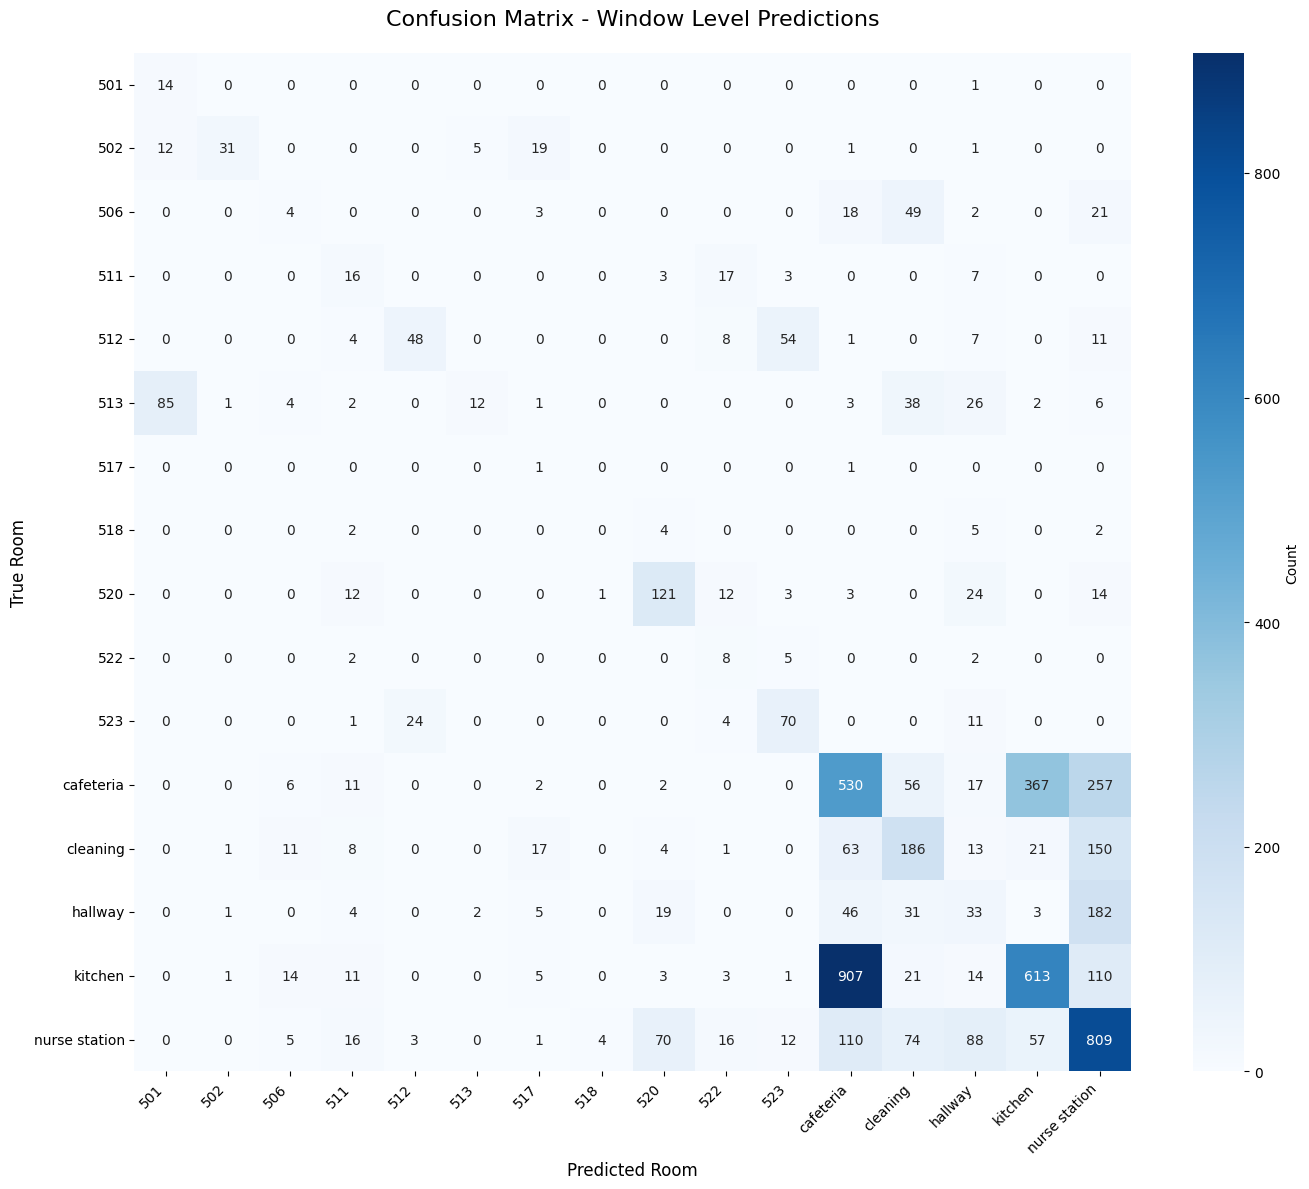


Total predictions: 5889
Correct predictions: 2496
Accuracy: 0.4238


In [35]:
# Confusion Matrix for WINDOW-LEVEL Predictions
print("=" * 80)
print("CONFUSION MATRIX - WINDOW LEVEL")
print("=" * 80)

# Get the 16 classes (sorted for consistent ordering)
classes = sorted(train_df['room'].unique())

# Compute confusion matrix
cm_window = confusion_matrix(y_test, y_pred_windowed, labels=classes)

# Create figure
plt.figure(figsize=(14, 12))
sns.heatmap(cm_window, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Window Level Predictions', fontsize=16, pad=20)
plt.xlabel('Predicted Room', fontsize=12)
plt.ylabel('True Room', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTotal predictions: {cm_window.sum()}")
print(f"Correct predictions: {np.trace(cm_window)}")
print(f"Accuracy: {np.trace(cm_window) / cm_window.sum():.4f}")


CONFUSION MATRIX - FRAME LEVEL


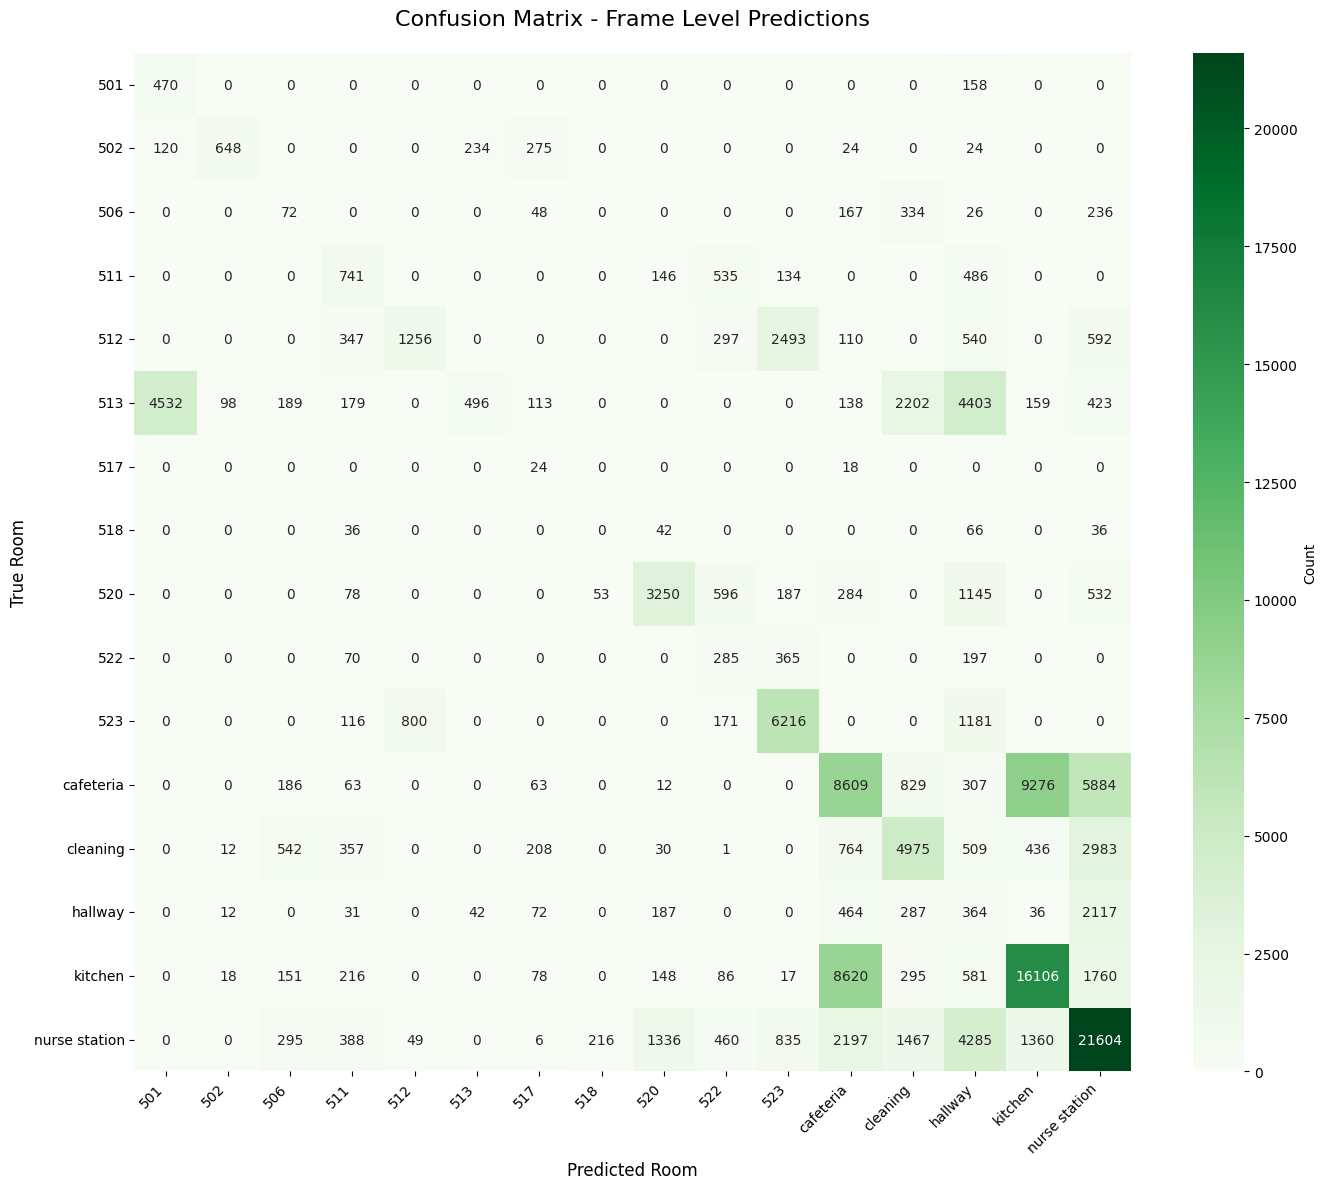


Total predictions: 141425
Correct predictions: 65116
Accuracy: 0.4604

SIDE-BY-SIDE COMPARISON


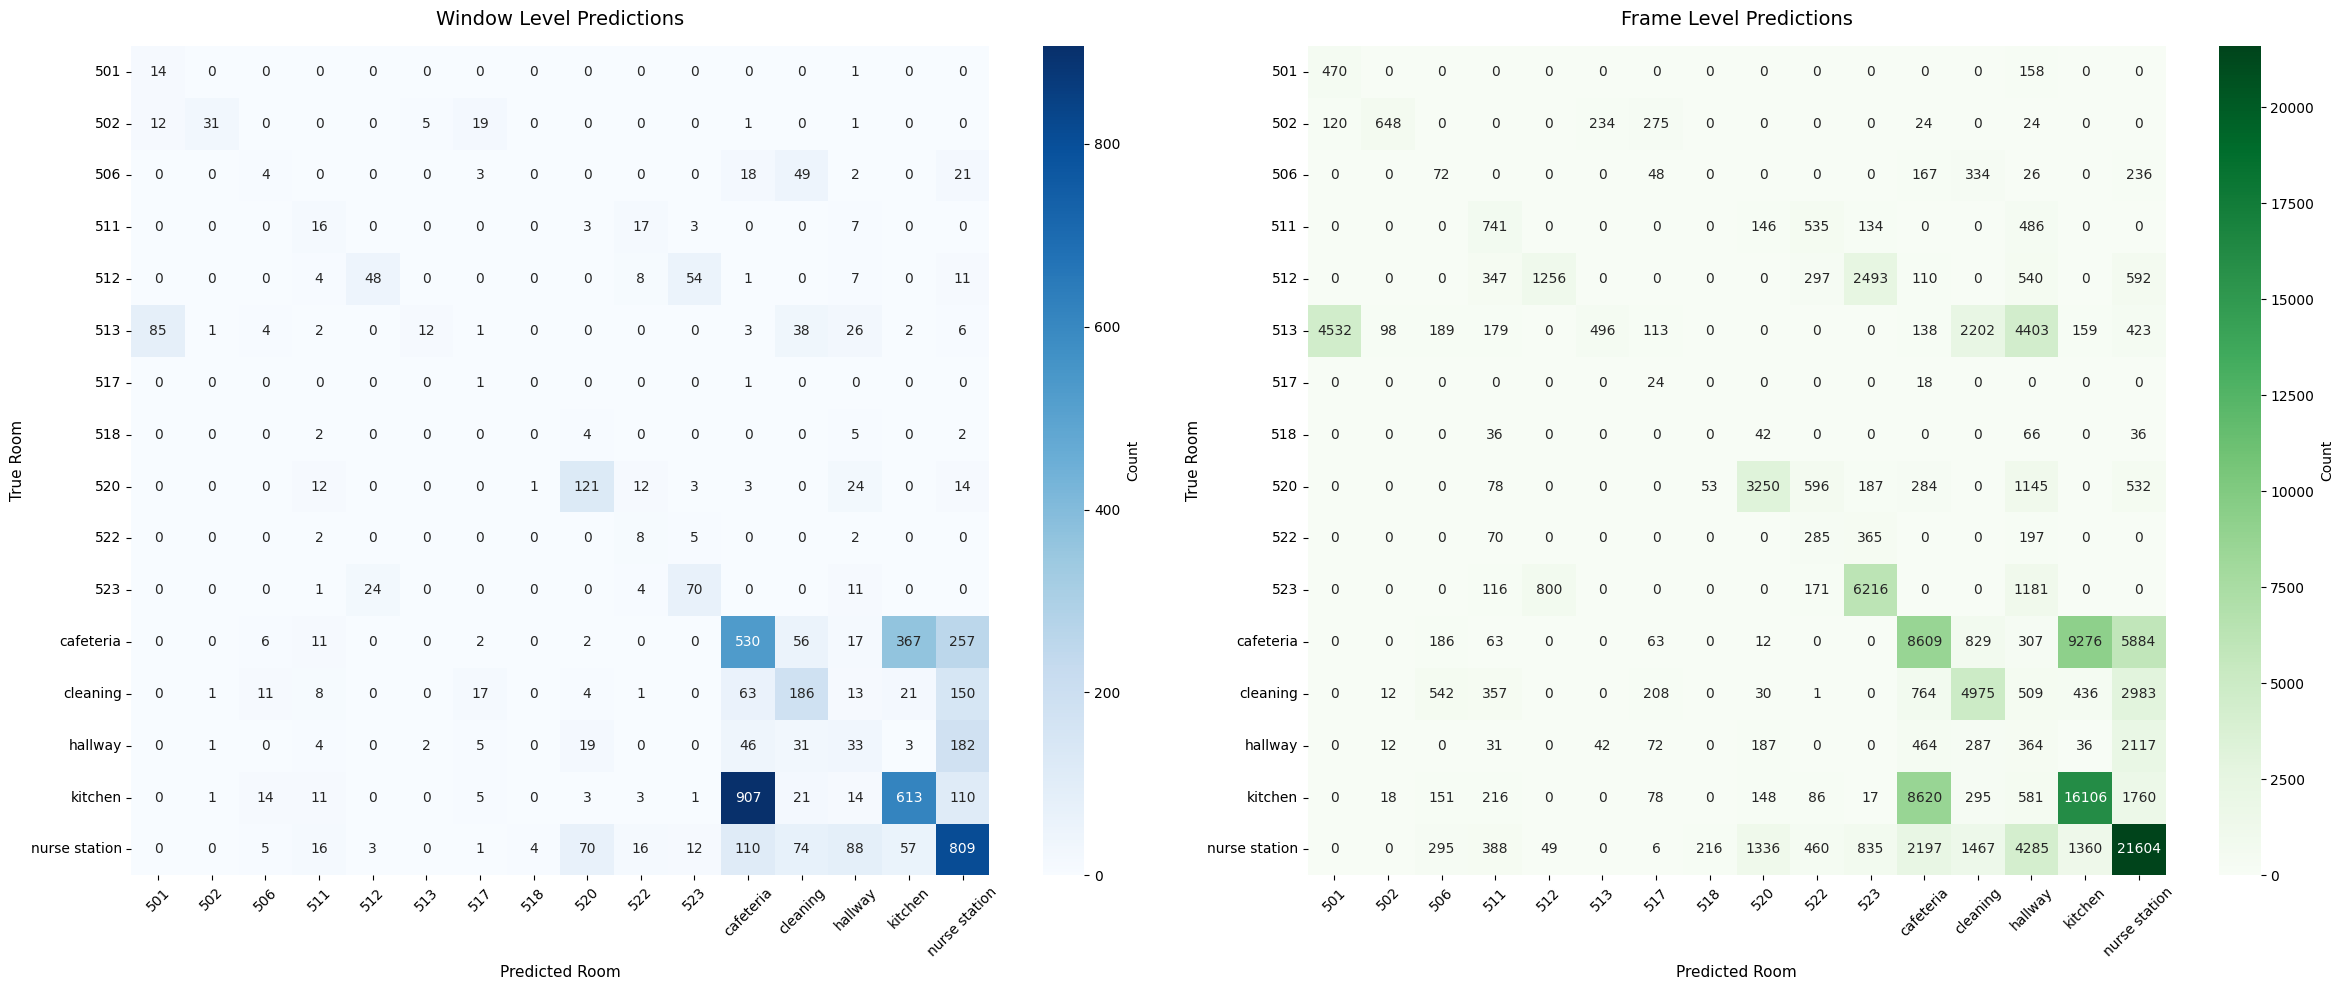


ACCURACY COMPARISON
Window-Level Accuracy: 0.4238
Frame-Level Accuracy:  0.4604
Difference:            0.0366


In [36]:
# Confusion Matrix for FRAME-LEVEL Predictions
print("\n" + "=" * 80)
print("CONFUSION MATRIX - FRAME LEVEL")
print("=" * 80)

# Compute confusion matrix
cm_frame = confusion_matrix(y_true_frames, y_pred_frames, labels=classes)

# Create figure
plt.figure(figsize=(14, 12))
sns.heatmap(cm_frame, 
            annot=True, 
            fmt='d', 
            cmap='Greens',
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Frame Level Predictions', fontsize=16, pad=20)
plt.xlabel('Predicted Room', fontsize=12)
plt.ylabel('True Room', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTotal predictions: {cm_frame.sum()}")
print(f"Correct predictions: {np.trace(cm_frame)}")
print(f"Accuracy: {np.trace(cm_frame) / cm_frame.sum():.4f}")


# Cell 3: Side-by-Side Comparison (OPTIONAL - if you want both in one view)
print("\n" + "=" * 80)
print("SIDE-BY-SIDE COMPARISON")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Window-level
sns.heatmap(cm_window, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Count'},
            ax=axes[0])
axes[0].set_title('Window Level Predictions', fontsize=14, pad=15)
axes[0].set_xlabel('Predicted Room', fontsize=11)
axes[0].set_ylabel('True Room', fontsize=11)
axes[0].tick_params(axis='x', rotation=45)

# Frame-level
sns.heatmap(cm_frame, 
            annot=True, 
            fmt='d', 
            cmap='Greens',
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Count'},
            ax=axes[1])
axes[1].set_title('Frame Level Predictions', fontsize=14, pad=15)
axes[1].set_xlabel('Predicted Room', fontsize=11)
axes[1].set_ylabel('True Room', fontsize=11)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Comparison summary
print("\n" + "=" * 80)
print("ACCURACY COMPARISON")
print("=" * 80)
window_acc = np.trace(cm_window) / cm_window.sum()
frame_acc = np.trace(cm_frame) / cm_frame.sum()

print(f"Window-Level Accuracy: {window_acc:.4f}")
print(f"Frame-Level Accuracy:  {frame_acc:.4f}")
print(f"Difference:            {frame_acc - window_acc:.4f}")
